In [ ]:
!pip install torchvision scikit-image pillow==4.1.1

     |████████████████████████████████| 11.3MB 15.1MB/s 
     |████████████████████████████████| 112kB 56.0MB/s 
  Created wheel for pillow: filename=Pillow-4.1.1-cp37-cp37m-linux_x86_64.whl size=1009687 sha256=ce5936c9e5f1a9ca8e207a47e5a9cdadffab56ac661ee05c4fdc3f817b8b740c
  Stored in directory: /root/.cache/pip/wheels/3f/f3/3e/f24b51fe136968f797933559011acd48b16708fc306c924770
  Created wheel for olefile: filename=olefile-0.46-py2.py3-none-any.whl size=35416 sha256=f8a716972de5026b8e42f6e7e4519e26960ad94b45be393feffb5bc9e056eaf1
  Stored in directory: /root/.cache/pip/wheels/4b/f4/11/bc4166107c27f07fd7bba707ffcb439619197638a1ac986df3
Successfully built pillow olefile
ERROR: scikit-image 0.16.2 has requirement pillow>=4.3.0, but you'll have pillow 4.1.1 which is incompatible.
ERROR: bokeh 2.3.1 has requirement pillow>=7.1.0, but you'll have pillow 4.1.1 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is inco

In [ ]:
# For plotting
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# For conversion
from skimage.color import lab2rgb, rgb2lab, rgb2gray
from skimage import io
# For everything
import torch
import torch.nn as nn
import torch.nn.functional as F
# For our model
import torchvision
import torchvision.models as models
from torchvision import datasets, transforms
# For utilities
import os, shutil, time


In [ ]:
use_gpu = torch.cuda.is_available()

In [ ]:
!wget http://data.csail.mit.edu/places/places205/testSetPlaces205_resize.tar.gz
!tar -xzf testSetPlaces205_resize.tar.gz

--2021-05-04 15:52:40--  http://data.csail.mit.edu/places/places205/testSetPlaces205_resize.tar.gz
Resolving data.csail.mit.edu (data.csail.mit.edu)... 128.52.129.40
Connecting to data.csail.mit.edu (data.csail.mit.edu)|128.52.129.40|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2341250899 (2.2G) [application/octet-stream]
Saving to: ‘testSetPlaces205_resize.tar.gz’

testSetPlaces205_re 100%[===================>]   2.18G  11.4MB/s    in 2m 47s  

2021-05-04 15:55:27 (13.4 MB/s) - ‘testSetPlaces205_resize.tar.gz’ saved [2341250899/2341250899]



In [ ]:
!tar -xzf /content/testSetPlaces205_resize.tar.gz.1

In [ ]:
import os
import shutil
os.makedirs('images/train/class/', exist_ok=True) # 40,000 images
os.makedirs('images/val/class/', exist_ok=True)   #  1,000 images
for i, file in enumerate(os.listdir('testSet_resize')):
  if i < 1000: # first 1000 will be val
    shutil.move('testSet_resize/' + file, 'images/val/class/' + file)
  else: # others will be val
    shutil.move('testSet_resize/' + file, 'images/train/class/' + file)


In [ ]:
len(os.listdir("/content/images/train/class"))

40000

In [ ]:
class ColorizationNet(nn.Module):
  def __init__(self, input_size=128):
    super(ColorizationNet, self).__init__()

    MIDLEVEL_FEATURE_SIZE = 128
    resnet=models.resnet18(pretrained=True)
    resnet.conv1.weight=nn.Parameter(resnet.conv1.weight.sum(dim=1).unsqueeze(1))
    
    self.midlevel_resnet =nn.Sequential(*list(resnet.children())[0:6])

    self.upsample = nn.Sequential(     
      nn.Conv2d(MIDLEVEL_FEATURE_SIZE, 128, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(128),
      nn.ReLU(),
      nn.Upsample(scale_factor=2),
      nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.Upsample(scale_factor=2),
      nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(32),
      nn.ReLU(),
      nn.Conv2d(32, 2, kernel_size=3, stride=1, padding=1),
      nn.Upsample(scale_factor=2)
    )

  def forward(self, input):

    # Pass input through ResNet-gray to extract features
    midlevel_features = self.midlevel_resnet(input)

    # Upsample to get colors
    output = self.upsample(midlevel_features)
    return output

    

In [ ]:
model=ColorizationNet()

In [ ]:
model(torch.rand(1,1,224,224)).shape

torch.Size([1, 2, 224, 224])

In [ ]:
class GrayscaleImageFolder(datasets.ImageFolder):
  '''Custom images folder, which converts images to grayscale before loading'''
  def __getitem__(self, index):
    path, target = self.imgs[index]
    img = self.loader(path)
    if self.transform is not None:
      img_original = self.transform(img)
      img_original = np.asarray(img_original)
      img_lab = rgb2lab(img_original)
      img_lab = (img_lab + 128) / 255
      img_ab = img_lab[:, :, 1:3]
      img_ab = torch.from_numpy(img_ab.transpose((2, 0, 1))).float()
      img_original = rgb2gray(img_original)
      img_original = torch.from_numpy(img_original).unsqueeze(0).float()
    if self.target_transform is not None:
      target = self.target_transform(target)
    return img_original, img_ab, target

In [ ]:
train_transforms = transforms.Compose([transforms.RandomResizedCrop(224), transforms.RandomHorizontalFlip()])
train_imagefolder = GrayscaleImageFolder('images/train', train_transforms)
train_loader = torch.utils.data.DataLoader(train_imagefolder, batch_size=64, shuffle=True)


In [ ]:
len(train_loader)

625

In [ ]:
# class AverageMeter(object):
#   '''A handy class from the PyTorch ImageNet tutorial''' 
#   def __init__(self):
#     self.reset()
#   def reset(self):
#     self.val, self.avg, self.sum, self.count = 0, 0, 0, 0
#   def update(self, val, n=1):
#     self.val = val
#     self.sum += val * n
#     self.count += n
#     self.avg = self.sum / self.count



In [ ]:
out.de.shape

NameError: ignored

In [ ]:
input.shape

AttributeError: ignored

In [ ]:
plt.imshow(show_output(input.squeeze(0),out.squeeze(0).cpu()))

NameError: ignored

In [ ]:
def train(train_loader, model, criterion, optimizer, epoch):
  print('Starting training epoch {}'.format(epoch))
  model.train()

  for i, (input_gray, input_ab, target) in enumerate(train_loader):
    
    if use_gpu: input_gray, input_ab, target = input_gray.cuda(), input_ab.cuda(), target.cuda()

    output_ab = model(input_gray) 
    loss = criterion(output_ab, input_ab) 
    # losses.update(loss.item(), input_gray.size(0))

    # Compute gradient and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print model accuracy -- in the code below, val refers to value, not validation
    if i % 25 == 0:
      print('Epoch: [{0}][{1}/{2}]\t'
            'Loss {loss:.4f} ({loss:.4f})\t'.format(
              epoch, i, len(train_loader), loss=loss)) 

  print('Finished training epoch {}'.format(epoch))


In [ ]:
from IPython.display import Image, display
display(Image(filename='/content/images/val/class/000d91ee9907dc11ecb76a0d4dd54cec.jpg'))

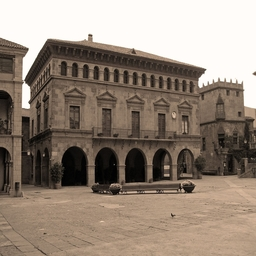

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
im=cv2.imread("/content/images/val/class/00bd27e623e062785c317ef58ad6e7c0.jpg")
cv2_imshow(im)

# lab=rgb2lab(im)
# cv2_imshow(lab)


In [ ]:
lab.shape

(256, 256, 3)

In [ ]:
im.shape

(256, 256, 3)

In [ ]:
if use_gpu: 
  criterion = criterion.cuda()
  model = model.cuda()


NameError: ignored

In [ ]:

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-6, weight_decay=0.0)
model=model.cuda()

for epoch in range(2):
  # Train for one epoch, then validate
  train(train_loader, model, criterion, optimizer, epoch)
  # torch.save(model.state_dict(), 'checkpoints/model-epoch-{}-losses-{:.3f}.pth'.format(epoch+1,loss))


Starting training epoch 0
Epoch: [0][0/625]	Loss 0.0031 (0.0031)	
Epoch: [0][25/625]	Loss 0.0023 (0.0023)	
Epoch: [0][50/625]	Loss 0.0029 (0.0029)	
Epoch: [0][75/625]	Loss 0.0022 (0.0022)	
Epoch: [0][100/625]	Loss 0.0024 (0.0024)	
Epoch: [0][125/625]	Loss 0.0028 (0.0028)	
Epoch: [0][150/625]	Loss 0.0033 (0.0033)	
Epoch: [0][175/625]	Loss 0.0024 (0.0024)	
Epoch: [0][200/625]	Loss 0.0023 (0.0023)	
Epoch: [0][225/625]	Loss 0.0025 (0.0025)	
Epoch: [0][250/625]	Loss 0.0029 (0.0029)	
Epoch: [0][275/625]	Loss 0.0024 (0.0024)	
Epoch: [0][300/625]	Loss 0.0023 (0.0023)	
Epoch: [0][325/625]	Loss 0.0027 (0.0027)	
Epoch: [0][350/625]	Loss 0.0024 (0.0024)	
Epoch: [0][375/625]	Loss 0.0028 (0.0028)	
Epoch: [0][400/625]	Loss 0.0033 (0.0033)	
Epoch: [0][425/625]	Loss 0.0026 (0.0026)	
Epoch: [0][450/625]	Loss 0.0020 (0.0020)	
Epoch: [0][475/625]	Loss 0.0026 (0.0026)	
Epoch: [0][500/625]	Loss 0.0027 (0.0027)	
Epoch: [0][525/625]	Loss 0.0031 (0.0031)	
Epoch: [0][550/625]	Loss 0.0023 (0.0023)	
Epoch: [0][57

In [ ]:
torch.save(model, 'model-final.pth')

In [ ]:
torch.Tensor(rgb2gray(im)).unsqueeze(0).unsqueeze(0)

In [ ]:
model=torch.load("/content/model-final.pth")
# model=ColorizationNet().cuda()
# model.load_state_dict(torch.load("/content/drive/MyDrive/Datasets/Models/Image Colorizer/model-epoch-2.pth"))

In [ ]:
input=torch.Tensor(rgb2gray(im))
# out=model(input.cuda())
# out=(torch.cat([out,input],dim=1).squeeze(0)).permute([1,2,0])
# plt.imshow(out.detach().numpy())

In [ ]:
input.shape

torch.Size([1, 1, 256, 256])

In [ ]:
out.shape

torch.Size([1, 2, 256, 256])

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# shutil.copy("/content/model-epoch-2.pth","/content/drive/MyDrive/Datasets/Models/Image Colorizer")

In [ ]:
def show_output(grayscale_input, ab_input):
  '''Show/save rgb image from grayscale and ab channels
     Input save_path in the form {'grayscale': '/path/', 'colorized': '/path/'}'''
  color_image = torch.cat((grayscale_input, ab_input), 0).detach().numpy() # combine channels
  color_image = color_image.transpose((1, 2, 0))  # rescale for matplotlib
  color_image[:, :, 0:1] = color_image[:, :, 0:1] * 100
  color_image[:, :, 1:3] = color_image[:, :, 1:3] * 255 - 128   
  color_image = lab2rgb(color_image.astype(np.float64))
  grayscale_input = grayscale_input.squeeze().numpy()
  # plt.imshow(grayscale_input)
  # plt.imshow(color_image)
  return color_image


In [ ]:
model=model.cpu()


In [ ]:
def colorize(img_path,print_img=True):
    grayscale_input= torch.Tensor(rgb2gray(cv2.imread(img_path)))
    ab_input=model(grayscale_input.unsqueeze(0).unsqueeze(0)).squeeze(0)
    predicted=show_output(grayscale_input.unsqueeze(0), ab_input)
    plt.imshow(predicted)
    return predicted

array([[[0.85409894, 1.        , 1.        ],
        [0.85409894, 1.        , 1.        ],
        [0.9577819 , 0.98663187, 1.        ],
        ...,
        [0.91608953, 1.        , 0.98675312],
        [0.93832729, 0.99707143, 0.99439554],
        [0.93832729, 0.99707143, 0.99439554]],

       [[0.85409894, 1.        , 1.        ],
        [0.85409894, 1.        , 1.        ],
        [0.9577819 , 0.98663187, 1.        ],
        ...,
        [0.91608953, 1.        , 0.98675312],
        [0.93832729, 0.99707143, 0.99439554],
        [0.93832729, 0.99707143, 0.99439554]],

       [[0.93488699, 0.99802786, 0.99424297],
        [0.93488699, 0.99802786, 0.99424297],
        [0.8940924 , 1.        , 1.        ],
        ...,
        [1.        , 0.97380416, 1.        ],
        [1.        , 0.97547734, 1.        ],
        [1.        , 0.97547734, 1.        ]],

       ...,

       [[0.30110708, 0.3423891 , 0.31346269],
        [0.34478485, 0.38691484, 0.35732201],
        [0.39039825, 0

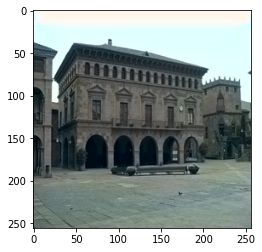

In [ ]:
colorize("/content/images/val/class/00bd27e623e062785c317ef58ad6e7c0.jpg")